# Neural Networks (Part 2): Going Deeper

In part 2 of this neural networks series of tutorials we'll go into some more advanced ideas that make it easier to train deeper neural networks. We'll discuss concepts like activation functions, schedulers, regularization, normalization, batches and dataloaders, and stochastic optimizers. We won't discuss new architectures yet, and just continue to stick with MLPs for now. Recall that an MLP is any neural network whose blocks are composed of linear layers + activation functions.

We'll again load the usual libraries we'll need, set a seed, and set a device for those who'd prefer to work on the GPU.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

seed = 12
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
def plot_data(X, y, X_test=None, y_test=None, model=None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]

    fig, ax = plt.subplots(figsize=(8, 8))


    classes = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if model is not None:
        grid = torch.from_numpy(grid).float()
        yhat = model(grid).argmax(dim=1).detach().numpy().reshape(xx.shape)
        ax.contourf(xx, yy, yhat, alpha=0.2, cmap=plt.cm.rainbow)
        plt.axis("tight")

    for j, color in zip(classes, colors):
        idx = np.where(y == j)
        alpha = 1 if X_test is None else 0.2
        plt.scatter(X[idx, 0], X[idx, 1], color=color, label=f'y={j}', edgecolor='black', s=15, alpha=alpha)
        if X_test is not None and y_test is not None:
            idx = np.where(y_test == j)
            plt.scatter(X_test[idx, 0], X_test[idx, 1], color=color, edgecolor='black', s=25, alpha=1)
    plt.title('Decision Surface')
    plt.axis('tight')

    ax.set(aspect='equal', xlabel='$x_1$', ylabel='$x_2$')
    ax.legend(loc='upper right')
    plt.show()

## Activation Functions

Recall that an activation function is any function that follows a linear layer. We've used sigmoid functions thus far for hidden layer activation functions. For output activation functions we've used linear, sigmoid, and softmax funtions.

It turns out that the sigmoid function 
$$\sigma(z) \equiv \frac{1}{1 + e^{-z}}$$ 
is a bad activation function to use for hidden layers. The reason for this is **gradient vanishing**. Because of the sigmoid's elongated S-shape, if $z$ isn't "small" in absolute value, e.g. $|z|=5$, then $\sigma(z)$ will be close to $\pm 1$. In these regions the sigmoid will be pretty flat, meaning its derivative (i.e. its gradient) will be approximately zero. When the gradient is approximately zero, gradient descent stops working, and those parameters don't update anymore. This causes the activations to die off, making them practically useless in the network. They can't contribute anymore to learning. Such dying activations have been shown to be common when one tries to use sigmoids hidden activations for deeper networks.

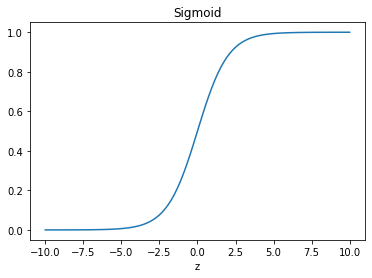

In [4]:
z = torch.linspace(-10, 10, 100)
sigmoid = F.sigmoid(z)
plt.plot(z.numpy(), sigmoid.numpy())
plt.xlabel('z')
plt.title('Sigmoid')
plt.show()

Because of this problem, many other activation functions have been proposed over the years and shown to work much better than the sigmoid for hidden layer activations. The most widely used is what's called the **rectified linear unit**, usually just called **ReLU**, defined by
$$
\text{ReLU}(z) \equiv \max(0, z) = 
\begin{cases}
0, & z < 0 \\
z, & z \geq 0.
\end{cases}
$$
This function is just a truncated line, with all the negative values set to zero.

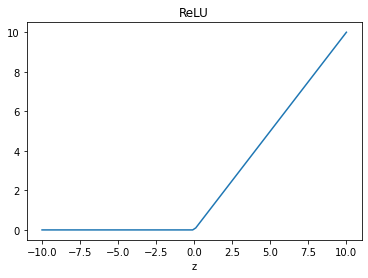

In [5]:
z = torch.linspace(-10, 10, 100)
relu = F.relu(z)
plt.plot(z.numpy(), relu.numpy())
plt.xlabel('z')
plt.title('ReLU')
plt.show()

The ReLU has turned out to work well across many experiments over the past decade for training neural networks, with gradient vanishing issues happening far less than sigmoids. Because of this, it's still by far the most widely used activation function today, even though minor variations of it have since come along and gained some degree of traction. Examples of these are the leaky ReLU, GELU, SELU, Swish, Mish, etc. We'll stick with ReLUs for most of our tutorials since it tends to work pretty well most of the time.

Using a ReLU in pytorch can be done either by using the layer `nn.ReLU` or the function `F.relu`. The other, newer variants just mentioned are accessible as well if you wish to use them.

**Note:** The ReLU is just used for *hidden layers*, not the output layer. For the output layer, you still want to use either the linear, sigmoid, or softmax activation depending on what your task is.

In [6]:
model = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
  (3): Sigmoid()
)

## Regularization

Recall from past tutorials that in practice it's usually bad to have zero loss or 100% accuracy on the training dataset, because it probably means you're just memorizing your data instead of discovering the underlying patterns in the data. This phenomenon is called **overfitting**. To help detect and prevent overfitting it's customary to keep a hold-out sample of the dataset that the model doesn't get trained on, and use that dataset to evaluate the performance of the model. Such hold-out datasets are called the **test set** or the **validation set**. A model trained on a training set that also performs well on the test set is said to **generalize**, just a fancy way of saying the model isn't just memorizing the data but actually learning its underlying patterns really well.

To see what overfitting looks like let's create a small linear dataset, split it into train and test sets, and try to fit the training set with a large MLP of 8 layers with hidden sizes of 500 neurons. We'll train it for 10,000 iterations on the training data (i.e. the grayed out data in the plot), and evaluate it on the test data (i.e. the black points in the plot). Note that the *true* fit should be a line in this case, as that's how we generated this dataset, a line plus some Gaussian noise.

In [7]:
num_samples = 30
X = torch.linspace(0, 5, num_samples).reshape(-1, 1).to(device)
y = X + torch.randn(num_samples).reshape(-1, 1).to(device)
X.shape, y.shape

(torch.Size([30, 1]), torch.Size([30, 1]))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([24, 1]),
 torch.Size([24, 1]),
 torch.Size([6, 1]),
 torch.Size([6, 1]))

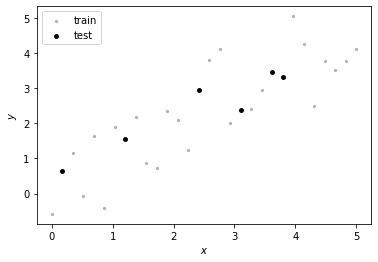

In [9]:
plt.scatter(X_train, y_train, label='train', color='gray', alpha=0.5, s=5)
plt.scatter(X_test, y_test, label='test', color='black', alpha=1, s=15)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left')
plt.show()

In [10]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).float().to(device)
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

num_features = X_train.shape[1]
num_hidden = 500
num_targets = 1

model = nn.Sequential(
    nn.Linear(num_features, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_targets)
)
model = model.to(device)
model

Sequential(
  (0): Linear(in_features=1, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): ReLU()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): ReLU()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): ReLU()
  (14): Linear(in_features=500, out_features=1, bias=True)
)

In [11]:
num_iters = 10_000
loss_fn = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)
for i in tqdm(range(num_iters)):
    # training
    opt.zero_grad()
    yhat = model(X_train)
    loss = loss_fn(yhat, y_train)
    loss.backward()
    opt.step()
    # inference
    yhat = model(X_test)
    test_loss = loss_fn(yhat, y_test)
    if i % (num_iters // 10) == 0:
        print(f'iter = {i} \t\t train loss = {loss / len(X_train)} \t\t test loss = {test_loss / len(X_test)}')
print(f'iter = {i} \t\t train loss = {loss / len(X_train)} \t\t test loss = {test_loss / len(X_test)}')

  0%|          | 0/10000 [00:00<?, ?it/s]

iter = 0 		 train loss = 0.30887994170188904 		 test loss = 1.0303691625595093
iter = 1000 		 train loss = 0.030806303024291992 		 test loss = 0.02472120337188244
iter = 2000 		 train loss = 0.029723338782787323 		 test loss = 0.029680581763386726
iter = 3000 		 train loss = 0.02871190570294857 		 test loss = 0.032898325473070145
iter = 4000 		 train loss = 0.027320751920342445 		 test loss = 0.03407188132405281
iter = 5000 		 train loss = 0.02563592977821827 		 test loss = 0.031092137098312378
iter = 6000 		 train loss = 0.02366632968187332 		 test loss = 0.03314466401934624
iter = 7000 		 train loss = 0.017538730055093765 		 test loss = 0.036950331181287766
iter = 8000 		 train loss = 0.011787530966103077 		 test loss = 0.031028496101498604
iter = 9000 		 train loss = 0.013204634189605713 		 test loss = 0.052232775837183
iter = 9999 		 train loss = 0.008932610973715782 		 test loss = 0.08386954665184021


Notice how the training loss is extremely low, almost zero, while the test loss is over an order of magnitude higher higher, and in fact getting *worse* with training. This is the hallmark of overfitting. We can visualize what's happening as well. Here's what our prediction looks like, overlaid on the above plot. Notice how jagged the curve is. It's practically just connecting the dots in the training set, which isn't helping it fit the test set at all.

**Remark:** You actually don't even need a model this big to overfit this dataset. Since there are 24 points in the training set, you only need 23 parameters to fit the training set perfectly with a degree 23 polynomial. Feel free to try it. Just create a linear model with features $x_1=x, x_2=x^2, x_3=x^3, \cdots, x_{23}=x^{23}$ and fit it to this dataset.

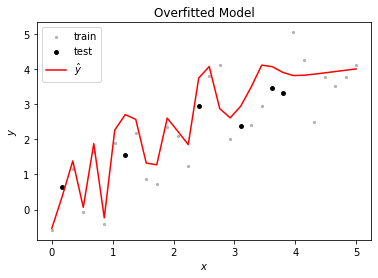

In [12]:
yhat = model(X)
plt.scatter(X_train.cpu().numpy(), y_train.cpu().numpy(), label='train', color='gray', alpha=0.5, s=5)
plt.scatter(X_test.cpu().numpy(), y_test.cpu().numpy(), label='test', color='black', alpha=1, s=15)
plt.plot(X.cpu().numpy(), yhat.detach().cpu().numpy(), label='$\hat y$', color='red')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Overfitted Model')
plt.show()

Why did we overfit this dataset? Well, we specified a huge model to fit only 30 points! Just how big is this model? We can get that with the following function, which uses the pytorch `numel` method to get how many elements are in a tensor, and uses this method on all parameter tensors in the model, and sums them up to get the total number. It looks like this neural network already has over 1.5 million parameters! It's no surprise that a model that big can easily overfit a dataset with just 30 points.

In [13]:
def num_params(model):
    return sum([p.numel() for p in model.parameters()])

num_params(model)

1504501

Supposing we were dead set to use this model on this dataset, what could we do to improve results? It turns out there exist a whole set of techniques called **regularization** that can help make it harder for large models to overfit the dataset.

Traditionally, the most common thing we might do if our model was overfitting would be to decrease the size of the model. Instead of a complicated model like an 8-layer neural network, maybe use a simpler model like a shallow network or perhaps just linear regression. In the age of deep learning though this approach is less advised. The reason being that you can often *still* get better results with a deeper network than a shallow network, even if you have lots more parameters that can overfit. There are better ways to deal with overfitting. Here are a few.

### Weight Decay

The simplest such regularization technique is called **weight decay** or **L2 regularization**. The idea here is to add a penalty term to the loss function that discourages it from letting weights grow too large during training. The closer the weights are to zero, the more the model acts like it has fewer parameters, since zeroing weights tends to zero out neurons. Suppose you have a loss function $L(\hat y, y)$ and your neural network has total weights
$$w \equiv (w_1,w_2,\cdots,w_m).$$
Then we can define an L2-regularized loss function $L_R(\hat y, y)$ by
$$L_R(\hat y, y) \equiv L(\hat y, y) + \frac{\lambda}{2N} w\cdot w = L(\hat y, y) + \frac{\lambda}{2N} \big(w_1^2 + w_2^2 + \cdots + w_m^2 \big).$$
That is, it's just the regular loss added to a *penalty term* that's a just a sum of squares of *every single weight* in your neural network. The value $\lambda$ is the **weight decay rate**. It's another tunable hyperparameter you specify in advance when training a model.

To see what weight decay does, remember that the goal of training is to minimize the (regularized) loss $L_R(\hat y, y)$. With the added penalty term $\frac{\lambda}{2N} w\cdot w$, the model will want to try to keep the weights small during training so that this term doesn't blow up. The weight decay rate $\lambda$ controls the tradeoff between how badly the model wants to do well on fitting the dataset (the regular loss term), and how badly it wants to keep the weights small (the penalty term). Setting $\lambda$ appropriately creates a good tradeoff between these two competing objectives.

**Note:** The biases aren't generally affected by weight decay. It's only the weights we worry about blowing up. The biases are just additive terms, and there are far fewer of them than weights, so they contribute less to training.

In practice, weight decay is usually defined on the gradient descent updates instead of directly on the loss function itself. The mathematically inclined can show that the regularized gradient updates are given by
$$\boldsymbol{W}_{n+1} = \boldsymbol{W}_n - \alpha \frac{dL_R(\boldsymbol{W}_n,\boldsymbol{b}_n)}{d\boldsymbol{W}} = \bigg(1 - \frac{\lambda}{N}\bigg)\boldsymbol{W}_n - \alpha \frac{dL(\boldsymbol{W}_n,\boldsymbol{b}_n)}{d\boldsymbol{W}},$$
$$\boldsymbol{b}_{n+1} = \boldsymbol{b}_n - \alpha \frac{dL_R(\boldsymbol{W}_n,\boldsymbol{b}_n)}{d\boldsymbol{b}} = \boldsymbol{b}_n - \alpha \frac{dL(\boldsymbol{W}_n,\boldsymbol{b}_n)}{d\boldsymbol{b}}.$$

Notice the terms on the right involve gradients of the original loss $L$, not the regularized loss $L_R$. They look exactly like the usual gradient updates, except the weights get decayed by a factor of $\big(1 - \frac{\lambda}{N}\big)$ on each update, hence the name "weight decay". It's in this form that weight decay is typically implemented in practice.

In pytorch, we can use weight decay by just passing in the value $\lambda$ that we want directly into the optimizer with the keyword `weight_decay`. Let's see if we can train a better model to fit the above dataset using weight decay.

### Dropout

Another way to regularize a model that's neural network specific is to use a special "layer" called **dropout**. The idea is this: A model is more likely to overfit when any one neuron is allowed to dominate a prediction too much. We can thus regularize by preventing any one neuron from becoming too influential during training.

During **training** we can do the following:
- For a given hidden layer $\ell$ with $n_h$ hidden units, take its post activation outputs $a$, which will have $n_h$ different values (the neurons of that layer).
- Instead of feeding all $n_h$ hidden units of $a$ to the next linear layer, randomly sample a certain fraction $p$ of them to mask (i.e. zero out temporarily so they won't affect the output).
- The other fraction $1-p$ we'll allow to pass into the activation function and affect the output.
- Each time we pass through the layer, we sample a different set from $a$ than we did last time, but still only a $p$ fraction of them
- Do this each iteration, for each layer, until training is complete. Note each layer can have different fractions $p$ to mask.

Here's a figure showing what applying dropout during training looks like. For each iteration, i.e. each forward pass through the network, the ones that are X'd out will change, but the *number* that are X'd out will always be the same, depending on $p$.

<img src="https://miro.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png" alt="dropout" width="500">

When doing **inference** on the model, i.e. when making predictions after training, we don't want to keep dropout on. We want to use all the neurons we've got to ensure that our predictions aren't random, but completely stable and deterministic.

In pytorch, we can create a dropout layer using `nn.Dropout(p)`, where `p` is the fraction of neurons to mask as described above. During training we'll want dropout to be on. To make sure that's true we set `model = model.train()` before starting training. Once we're *done* training, we want to make sure dropout is turned off. We can do that by setting `model = model.eval()` before making predictions.

### Regularization Example

Let's use weight decay and dropout for the above example and see if we can reign in the overfitting. We'll use the same model as above, just with dropout added after each linear layer (except the output layer, you don't usually want one there). We'll take $p=0.2$ and $\lambda=0.001$. How did I arrive at this choice of hyperparameters, you might ask? Lots of times running this thing to see what would give the best result, with all the other hyperparameters from above fixed. Don't think I'm a magician and pulled them out of a hat or anything. Tuning neural nets is a whole lot of trial and error.

We can see that we've managed to *halve* our testerror here, but at the cost of the training error being higher. That's what regularization will often do. Notice also that the fitted curve looks a lot nicer than the other one. It's trying to smoothly fit the points better. It's not a line, but it's doing a good job.

In [14]:
p = 0.2

model = nn.Sequential(
    nn.Linear(num_features, num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_targets)
)
model = model.to(device)

In [15]:
num_iters = 10_000
loss_fn = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
for i in tqdm(range(num_iters)):
    # training
    model = model.train()
    opt.zero_grad()
    yhat = model(X_train)
    loss = loss_fn(yhat, y_train)
    loss.backward()
    opt.step()
    # inference
    model = model.eval()
    yhat = model(X_test)
    test_loss = loss_fn(yhat, y_test)
    if i % (num_iters // 10) == 0:
        print(f'iter = {i} \t\t train loss = {loss / len(X_train)} \t\t test loss = {test_loss / len(X_test)}')
print(f'iter = {i} \t\t train loss = {loss / len(X_train)} \t\t test loss = {test_loss / len(X_test)}')

  0%|          | 0/10000 [00:00<?, ?it/s]

iter = 0 		 train loss = 0.3189311921596527 		 test loss = 1.067847490310669
iter = 1000 		 train loss = 0.03205722197890282 		 test loss = 0.0249770674854517
iter = 2000 		 train loss = 0.028152383863925934 		 test loss = 0.021457595750689507
iter = 3000 		 train loss = 0.03488529846072197 		 test loss = 0.023753678426146507
iter = 4000 		 train loss = 0.03236726298928261 		 test loss = 0.039700400084257126
iter = 5000 		 train loss = 0.03180822357535362 		 test loss = 0.03295603394508362
iter = 6000 		 train loss = 0.031245656311511993 		 test loss = 0.04395035281777382
iter = 7000 		 train loss = 0.03394685313105583 		 test loss = 0.03648354485630989
iter = 8000 		 train loss = 0.028842834755778313 		 test loss = 0.03609803318977356
iter = 9000 		 train loss = 0.02666834555566311 		 test loss = 0.03168197348713875
iter = 9999 		 train loss = 0.028076164424419403 		 test loss = 0.03922378271818161


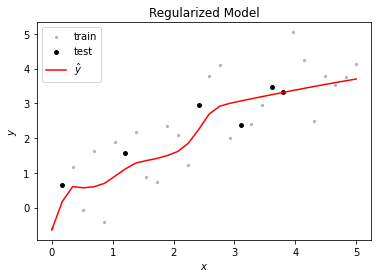

In [16]:
yhat = model(X)
plt.scatter(X_train.cpu().numpy(), y_train.cpu().numpy(), label='train', color='gray', alpha=0.5, s=5)
plt.scatter(X_test.cpu().numpy(), y_test.cpu().numpy(), label='test', color='black', alpha=1, s=15)
plt.plot(X.cpu().numpy(), yhat.detach().cpu().numpy(), label='$\hat y$', color='red')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Regularized Model')
plt.show()

## Normalization

It turns out that, like all parametric models, neural networks are strongly affected by the scale of the data. If features are way out of scale with each other the model will typically train poorly. For gradient descent to work, you'll either need to use a really small learning rate, or rescale your data prior to training. Since we want to use large learning rates and train our models quickly, rescaling the data seems like the smarter move. This is called **normalization**. In fact, with neural nets, we don't just want to normalize the data (i.e. the input layer), we want to normalize *all layers*. This will lead to layer normalization concepts like batch normalization and layer normalization.

Too see what normalization does, let's start with input layer normalization, i.e. normalizing the input features. Consider the following input data `X` with 100 examples of 3 features. We can see how skewed the features are by looking at a histogram of each feature and overlaying them on top of each other. In this case, it looks like the feature $x_0$ has a mean around 0 with a pretty large spread. Feature $x_1$ has a somewhat higher mean, but a smaller spread with a sharper peak. And feature $x_2$ has a much higher mean around 1000 and a still smaller spread and higher peak. It's not at all the case that these features are on the same scale.

In [17]:
def gen_data(n_samples, means, stds):
    x0 = stds[0] * torch.randn(n_samples).reshape(-1, 1) + means[0]
    x1 = stds[1] * torch.randn(n_samples).reshape(-1, 1) + means[1]
    x2 = stds[2] * torch.randn(n_samples).reshape(-1, 1) + means[2]
    return torch.cat([x0, x1, x2], dim=1)
    
x = gen_data(100, [1, 100, 1000], [100, 10, 1])
x.shape

torch.Size([100, 3])

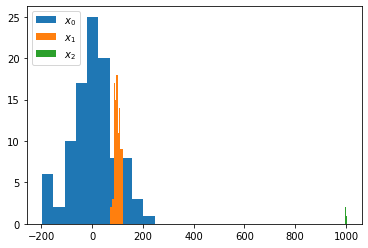

In [18]:
plt.hist(x[:, 0].numpy(), label='$x_0$')
plt.hist(x[:, 1].numpy(), label='$x_1$')
plt.hist(x[:, 2].numpy(), label='$x_2$')
plt.legend()
plt.show()

There are several ways to normalize data, with different domains often preferring different normalization methods. Probably the most common is **standardization**, a method from statistics where one normalizes each feature to have a mean 0 and standard deviation 1, called centering and scaling. If $x_j$ is a feature with mean $\mu_j$ and standard deviation $\sigma_j$, we can normalize it to a new feature standardized feature $\bar x_j$ via
$$\bar x_j \equiv \frac{x_j - \mu_j}{\sigma_j}.$$
By design, all $\bar x_j$ will have mean 0 and standard deviation 1. Note each feature will have its own $\mu_j$ and $\sigma_j$ to normalize by. You don't want to use the same $\mu$ and $\sigma$ for every feature or you haven't really normalized your data all.

Using broadcasting rules we can normalize a dataset `x` by subtracting a *row vector* of column means and dividing by a *row vector* of column standard deviations. It's a simple one-liner. Once we've done this, the histogram shows each feature to be a lot better scaled.

In [21]:
x_normed = (x - torch.mean(x, dim=0)) / torch.std(x, dim=0)
x_normed.shape

torch.Size([100, 3])

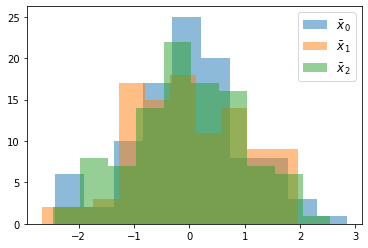

In [22]:
plt.hist(x_normed[:, 0].numpy(), label=r'$\bar x_0$', alpha=0.5)
plt.hist(x_normed[:, 1].numpy(), label=r'$\bar x_1$', alpha=0.5)
plt.hist(x_normed[:, 2].numpy(), label=r'$\bar x_2$', alpha=0.5)
plt.legend(fontsize=12)
plt.show()

### Batch Normalization

The real kick here is that with neural networks we want to do this for *each layer*, not just the inputs, as it will make training deeper networks much easier when neurons in a layer are on similar scales to each other. Generally we'll want to do this after each linear layer before applying the activation function. So if a linear layer has
$$\boldsymbol{z}_{\ell} = \boldsymbol{W}_{\ell} \boldsymbol{a}_{\ell-1} + \boldsymbol{b}_{\ell},$$
we'll want to normalize it to be
$$\boldsymbol{\hat z}_{\ell} \equiv \frac{\boldsymbol{z}_{\ell} - \boldsymbol{\mu}_{\ell}}{\boldsymbol{\sigma}_{\ell}},$$
where $\boldsymbol{\mu}_{\ell}$ is the mean of the inputs in layer $\ell$, and $\boldsymbol{\sigma}_{\ell}$ the standard deviation of those inputs.

Excuse the slight abuse of notation here. This formula is already assumed to be vectorized, hence the change to bolded notation. So $\boldsymbol{z}_{\ell}$ is a vector with $n_h$ features. And *each of those features* will be normalized by *its own mean and std*.

Now, it seems like the thing to do would be to pass $\boldsymbol{\hat z}_{\ell}$ into the activation function like we would usually do $\boldsymbol{z}_{\ell}$, but that's not quite what we want to do. The issue is that we have normalized our layer to have the same distribution, a Gaussian. But there's no a priori reason that those features should necessarily be Gaussians with mean 0 and std 1. We want our learned features to be as expressive as possible.

The trick for both 1) taking advantage of the benefits of normalized layers in training, while simultaneously 2) having features as expressive as possible can be accomplished as follows: What we'll do is, for each neuron in the layer, introduce two learned parameters, a scale parameter $\gamma_j$ and a shift parameter $\beta_j$.

For each hidden layer $\ell$ this will give two parameter vectors: a scale vector $\boldsymbol{\gamma}_{\ell}=(\gamma_1,\cdots,\gamma_{n_h})$, and a shift vector $\boldsymbol{\beta}_{\ell}=(\beta_1,\cdots,\beta_{n_h})$. Using these, we can *elementwise multiply* $\boldsymbol{\gamma}_{\ell}, \boldsymbol{\hat z}_{\ell}$ and add $\boldsymbol{\beta}_{\ell}$ to get the *final* linear layer outputs that'll then be fed into the activation function:
$$\boldsymbol{\tilde z}_{\ell} \equiv \boldsymbol{\gamma}_{\ell} \boldsymbol{\hat z}_{\ell} + \boldsymbol{\beta}_{\ell},$$
$$\boldsymbol{a}_{\ell} = f_{\ell}(\boldsymbol{\tilde z}_{\ell}).$$
These will allow each neuron to have its own mean and standard deviation, but only after we've normalized the data. The neural network can figure out for itself what the best choices for these parameters are by learning from the data. This technique is called **batch normalization** (batch norm), and has been shown to be very powerful in helping stably train deep neural networks of all kinds.

In pytorch, we can create a (1-dim) batch norm layer using `nn.BatchNorm1d`. If that layer has `num_hidden` neurons then batch norm will have `2 * num_hidden` parameters: `num_hidden` scale parameters $\boldsymbol{\gamma}$, and `num_hidden` shift parameters $\boldsymbol{\beta}$.

In [23]:
num_hidden = 3
batch_norm = nn.BatchNorm1d(num_hidden)
list(batch_norm.parameters()) # these are initialized param values, not yet learned

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

### Layer Normalization

For completeness, there's also another normalization technique related to batch norm that's becoming more popular, called **layer normalization** (layer norm). It's almost exactly the same as batch norm, except with one subtle difference: Instead of calculating $\boldsymbol{\mu}_{\ell}$ and $\boldsymbol{\sigma}_{\ell}$ across *all examples* in a batch for *each neuron*, they're calculated for *each example* separately across *all neurons* in the layer.

<img src="https://i.stack.imgur.com/E3104.png" alt="layer norm" width="500">

This very subtle change has increasingly been shown to work well in many applications, and is widely used in the most modern neural architectures, especially in sequential architectures like transformers and RNNs. Roughly speaking, right now it seems layer norms are more popular with NLP applications, and batch norms with computer vision applications. But this may well change in the next few years.

In pytorch, we can create a layer norm layer using `nn.LayerNorm`. It has the same number and type of parameters as batch norm does, they're just calculated slightly differently, as described above.

In [4]:
nn.LayerNorm?

In [24]:
num_hidden = 3
layer_norm = nn.LayerNorm(num_hidden)
list(layer_norm.parameters()) # these are initialized param values, not yet learned

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

## Example: MNIST

Let's apply batch norm to the MNIST dataset. Recall that this dataset consists of a few thousand images of 10  handwritten digits 0-9. There are 70,000 images of size 64x64, which when flattened become 768 features.

In [4]:
def get_mnist_data():
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.datasets import fetch_openml
    data = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = data[0].astype(float)
    X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
    y = data[1].astype(int)
    return X, y

X,y = get_mnist_data()
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [6]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9694

In [7]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).long().to(device)
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).long().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).long().to(device)

num_features = X_train.shape[1]
num_hidden = 500
num_targets = len(set(y_train))

In [8]:
p = 0.1
model = nn.Sequential(
    nn.Linear(num_features, num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Dropout(p=p),
    nn.Linear(num_hidden, num_targets)
)
model = model.to(device)

In [ ]:
num_iters = 10
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.)
for i in tqdm(range(num_iters)):
    # training
    model = model.train()
    opt.zero_grad()
    yhat = model(X_train)
    loss = loss_fn(yhat, y_train)
    loss.backward()
    opt.step()
    # inference
    model = model.eval()
    yhat = model(X_test)
    test_loss = loss_fn(yhat, y_test)
    if i % (num_iters // 10) == 0:
        print(f'iter = {i} \t\t train loss = {loss / len(X_train)} \t\t test loss = {test_loss / len(X_test)}')
print(f'iter = {i} \t\t train loss = {loss / len(X_train)} \t\t test loss = {test_loss / len(X_test)}')

  0%|          | 0/10 [00:00<?, ?it/s]

## Optimizers

In [ ]:
# scheduler = torch.optim.lr_scheduler.StepLR(opt, num_iters // 3, gamma=0.3)
# scheduler.step()